# **QACO: Quantum Ant Colony Optimization**

QACO is an hybrid quantum algorithm based on the classical Ant Colony Optimization algorithm to produce approximate solutions for NP-hard problems, in particular optimization problems.

In [35]:
# !pip install "qiskit==0.46.0" "qiskit-aer==0.13.3"

In [36]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

from pickle import NONE
import numpy as np
import random
import matplotlib.pyplot as plt
from math import pi, asin, sqrt, cos, sin


## **Parameters definition**

In [37]:
# Parametri QACO
beta_e0 = 0.13             # Probabilità esplorazione iniziale
maxIter = 62              # Numero massimo di iterazioni
converCondition = 59      # Condizione di convergenza
n = 4                     # Dimensione matrice M, il codice è comunque generalizzato nella funzione update_thetas
Converged_by_theta=False
problem_matrix = 5        # Choice of problem matrix (1, 2, 3, 4 or 5)

## **Load problem matrices**

In [38]:
import pandas as pd

def load_trial_matrix(problem_matrix):
    """Loads matrix M and solution vector X_th from CSV file"""
    file_path = f"../Trial_matrices/M{problem_matrix}.csv"
    data = pd.read_csv(file_path, header=None)
    
    M = data.iloc[:4, :].values  # First 4 rows = matrix
    X_th = data.iloc[4, :].values  # Last row = solution vector
    
    return M, X_th

In [39]:
# Visualization of matrix M
def plot_matrix(matrix, title="M Matrix Visualization"):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Create a custom color map
    # Negative values -> blue, positive values -> red
    colors = []
    for i in range(matrix.shape[0]):
        color_row = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                # Red intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1, 1-intensity, 1-intensity])  # Red with gradations
            elif matrix[i, j] < 0:
                # Blue intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1-intensity, 1-intensity, 1])  # Blue with gradations
            else:
                color_row.append([0.9, 0.9, 0.9])  # Light gray for zero
        colors.append(color_row)
    
    # Draw the matrix as image
    im = ax.imshow(colors, aspect='equal')
    
    # Add numerical values in cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Choose text color based on background
            text_color = 'black'
            
            # Format number for better readability
            value_text = f'{matrix[i, j]:.3f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=14, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', 
                           alpha=0.7,
                           edgecolor='none'))
    
    # Customize grid and labels
    ax.set_xlim(-0.5, matrix.shape[1]-0.5)
    ax.set_ylim(-0.5, matrix.shape[0]-0.5)
    
    # Add elegant gridlines
    for i in range(matrix.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=2)
    for j in range(matrix.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=2)
    
    # Axis labels
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(matrix.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(matrix.shape[0])])
    
    # Title and labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Destination Node', fontsize=8, fontweight='bold')
    ax.set_ylabel('Source Node', fontsize=8, fontweight='bold')
    
    # Remove tick marks for cleaner look
    ax.tick_params(length=0)
    
    plt.tight_layout()
    plt.show()

## **Pheromone initialization and new solution exploration**



In [40]:
_lookup_table = {
    (0,0,True): -0.01 * pi,
    (0,0,False): 0.04 * pi,
    (0,1,True): -0.05 * pi,
    (0,1,False): 0.07 * pi,
    (1,0,True): 0.05 * pi,
    (1,0,False): -0.07 * pi,
    (1,1,True): 0.01 * pi,
    (1,1,False): -0.04 * pi
}


def init_pheromones(theta_ant):
    #Initialize RY angles θ_i = π/2 for all ant qubits
    theta_ant=[pi/2]*n #n = 4
    return theta_ant

def exploration_angle(beta_e):
    #Compute θ_e = 2 * arcsin(√β_e)
    return 2.0 * asin(sqrt(beta_e))

def calculate_fitness(X, M):
    X = np.array(X, dtype=float)
    return float(X @ M @ X.T)

## **Pheromone update**

In [41]:
def quantum_iteration_circuit_qiskit(theta_ant, theta_e, backend_shots=1024, seed=None):

    #Creazione circuito quantistico
    n_local = len(theta_ant)  #4
    qc = QuantumCircuit(n_local + 1, n_local)

    #preparazione ant-qubit con RY(theta_i) su qubit 1..n
    for i in range(n_local):
      qc.ry(float(theta_ant[i]), i+1)

    # per ogni ant-qubit: preparazione exploration RY(theta_e), CX(0,i+1), reset(0)---> see the appendix 2 about the reset
    for i in range(n_local):
      qc.ry(float(theta_e), 0)
      qc.cx(0, i+1)
      qc.reset(0)

    #misura ant-qubit 1..n nei bit classici 0..n-1
    for i in range(n_local):
      qc.measure(i+1, i)

    #esecuzione con AerSimulator
    sim = AerSimulator()
    t_qc = transpile(qc, sim)

    run_args = {"shots": int(backend_shots)}

    if seed is not None:
                # seed_simulator e seed_transpiler sono argomenti utili per riproducibilità
        run_args["seed_simulator"] = int(seed)
        run_args["seed_transpiler"] = int(seed)

    job = sim.run(t_qc, **run_args)
    result = job.result()
    counts = result.get_counts()


    # invertiamo per ottenere ordine naturale q0..q_{n-1}

    #Prendi la bitstring più frequente e assicurati che sia stringa normale
    bitstring = max(counts, key=counts.get)
    if isinstance(bitstring, bytes):
        bitstring = bitstring.decode("utf-8")

    # Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
    bitstring = ''.join(ch for ch in bitstring if ch in ('0', '1'))
    measured_bits = [int(b) for b in bitstring[::-1]]

    #print("Bitstring misurata:", bitstring, "→", measured_bits)
    #print("Counts del circuito quantistico:   \n ", counts,"\n")
    #print(qc.draw())
    return measured_bits, counts



def lookup_delta_theta(xi, bi, is_current_better, theta_ant):
    key = (int(xi), int(bi), bool(is_current_better))
    base = _lookup_table[key]
    # righe “miglioramento” (is_current_better == True) sono soggette all’inversione
    if is_current_better and cos(theta_ant / 2) < 0:
        return -base
    return base

def update_thetas(theta_ant, measured_bits, best_bits, f_x, f_b):

    n = len(theta_ant)

    # Se best_bits è None (prima iterazione), definiamo bi = 0 per default

    for i in range(n):
        xi = measured_bits[i]
        bi = 0 if best_bits is None else best_bits[i]
        is_current_better = (f_x > f_b)
        delta = lookup_delta_theta(xi, bi, is_current_better, theta_ant[i])
        theta_new = theta_ant[i] + delta

        # Clip θ_i nell’intervallo [0, π]
        if theta_new < 0.0:
            theta_new = 0.0
        if theta_new > pi:
            theta_new = pi

        theta_ant[i] = theta_new


    global Converged_by_theta
    tol = 1e-5  # tolleranza numerica

    if all(
        np.isclose(t, 0, atol=tol) or
        np.isclose(t, np.pi, atol=tol)
        for t in theta_ant
    ):
        Converged_by_theta = True

    return theta_ant, Converged_by_theta

## **Algorithm**

In the following functions the code is run `n_runs` times in order to calculate error percentage and the mean number of iterations.

In [42]:
def qaco_run_main(M, beta_e0=0.13, seed=None, backend_shots=1024, verbose=False):
    rng = np.random.default_rng(seed)
    n = M.shape[0]
    theta_ant=[0]*n
    best_bits=[0]*n

    theta_ant = init_pheromones(theta_ant)
    best_solution = None
    best_fitness = -np.inf

    print(f"QACO run (n={n})")
    print(f"converCondition = {converCondition}, maxIter = {maxIter}\n")

    global Converged_by_theta # Accedi alla variabile globale
    Converged_by_theta = False # Reset della condizione di convergenza dei theta all'inizio di ogni run

    for iter_num in range(1, maxIter + 1):
        #print(f"Iter {iter_num:3d} \n")

        #Aggiorna beta_e e theta_e
        beta_e = beta_e0 + (1.0 - beta_e0) * (iter_num / maxIter)
        theta_e=exploration_angle(beta_e)

        #Memorizza la best precedente
        f_prev_best = -np.inf if best_bits is None else calculate_fitness(best_bits, M)

        #Esegui il circuito quantistico (singolo shot)
        measured_bits, counts = quantum_iteration_circuit_qiskit(theta_ant, theta_e, backend_shots=backend_shots, seed=seed)

        #Calcola la fitness
        fitness=calculate_fitness(measured_bits, M)

        #Aggiorna i θ_i con la lookup table
        theta_ant, Converged_by_theta = update_thetas(theta_ant, measured_bits, best_bits, fitness, f_prev_best)

        #Aggiorna best se necessario
        if fitness > best_fitness:
            best_fitness = fitness
            best_bits = measured_bits.copy()
            conver_counter = 0
        else:
            conver_counter += 1

        #Stampa risultati
        if verbose:
            print(f"measured final bit={measured_bits} "
                  f"f_x={fitness:.5f} | best_f={best_fitness:.5f} "
                  f"conv={conver_counter}/{converCondition} ")
            if Converged_by_theta:
                print(" (Convergenza per theta raggiunta!)\n ")
            else:
                print("\n")

        # (8) Condizione di convergenza
        if conver_counter >= converCondition:
            print("\nConvergenza raggiunta per condizione standard!")
            break
        # Nuova condizione di convergenza basata su theta_ant
        # if Converged_by_theta:
        #     print("\nConvergenza raggiunta: tutti i theta sono 0 o pi/2!")
        #     break


    # Risultato finale
    print("\nRISULTATO FINALE")
    print("Best solution:", best_bits)
    print("Best fitness :", best_fitness)
    print("Iterations   :", iter_num)
    if conver_counter < converCondition and not Converged_by_theta:
       print("NOT CONVERGED")
    else:
        print("Converged: True") # Aggiunto per chiarezza sul perché si è fermato
    print("\n")

    return best_bits, iter_num

In [43]:
def multiple_runs(M, X, n_runs):
  #scorro sul vettore soluzione e conto gli 1's per impostare m

  run = 1
  error_count = 0
  sum = 0
  for run in range(n_runs):
      print("Iteraton number: ", run)

      best_bits, iter_num = qaco_run_main(M,
                                 beta_e0=0.13,
                                 seed=None,
                                 backend_shots=1024,
                                 verbose=False)
      if not np.array_equal(np.asarray(X), np.asarray(best_bits)):
          error_count += 1

      sum = sum + iter_num
  iter_mean = sum/n_runs
  print(f"Error probability: {((error_count/run)*100):.2f}%")
  print(f"Mean iterations: {iter_mean}")

## **Simulation**

### **Single simulation**

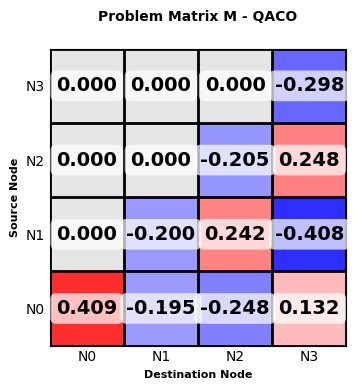

In [44]:
M, X_th = load_trial_matrix(problem_matrix)
plot_matrix(M, "Problem Matrix M - QACO")

In [45]:
qaco_run_main(M, beta_e0=0.13, seed=None, backend_shots=1024, verbose=False)

QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True




([1, 0, 0, 0], 62)

### **Multiple simulations**

In [47]:
multiple_runs(M, X_th, 1000)

Iteraton number:  0
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True


Iteraton number:  1
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True


Iteraton number:  2
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True


Iteraton number:  3
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True


Iteraton number:  4
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness : 0.409
Iterations   : 62
Converged: True


Iteraton number:  5
QACO run (n=4)
converCondition = 59, maxIter = 62


RISULTATO FINALE
Best solution: [1, 0, 0, 0]
Best fitness 